In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [19]:
df_train = pd.read_csv('./anomaly_detection_dataset_2022/trainset.csv')
df_train = df_train.drop(columns=['created_at'])
df_train.shape

(45395, 18)

In [20]:
# Does it make sense to scale? Yes, because value ranges differ a lot.
# e.g, human_num is a small integer value, while some values range in
# hundreds. This means human_num will be mostly ignored and have no effect
# in in the data. Very little variance compare to other features, even though
# the different between 0 and 1 is a big thing.
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train_data = scaler.transform(df_train)

# Determine Hyperparameters
[Ref](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd)
and Wikipedia
* Usually, if `dim > 2`, choose `minPts = dim * 2`.
* If data is noisier, try to use larger values of `minPts`.

In [21]:
dim = scaled_train_data.shape[1]
computed_minPts = dim * 2
print(f'computed_minPts: {computed_minPts}')


computed_minPts: 36


In [22]:
neighbors = NearestNeighbors(n_neighbors=computed_minPts)
neighbors_fit = neighbors.fit(scaled_train_data)
distances, indices = neighbors_fit.kneighbors(scaled_train_data)

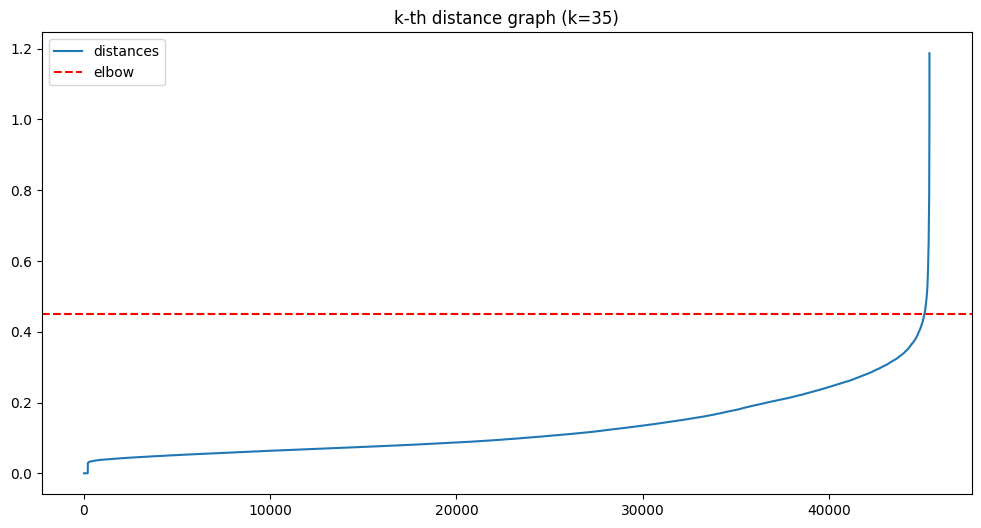

In [23]:
distances = np.sort(distances, axis=0)
k = computed_minPts-1
kth_distances = distances[:, k-1]

# the elbow was determined by eye.
elbow = 0.45
computed_epsilon = elbow

plt.figure(figsize=(12,6))
plt.plot(kth_distances, label='distances')
plt.axhline(elbow, c='red', linestyle='--', label='elbow')
plt.title(f'k-th distance graph (k={k})')
plt.legend()
plt.show()

# Fit and visualize cluster

In [24]:
db = DBSCAN(eps=computed_epsilon, min_samples=computed_minPts).fit(scaled_train_data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}/{scaled_train_data.shape[0]}')


Estimated number of clusters: 5
Estimated number of noise points: 57/45395


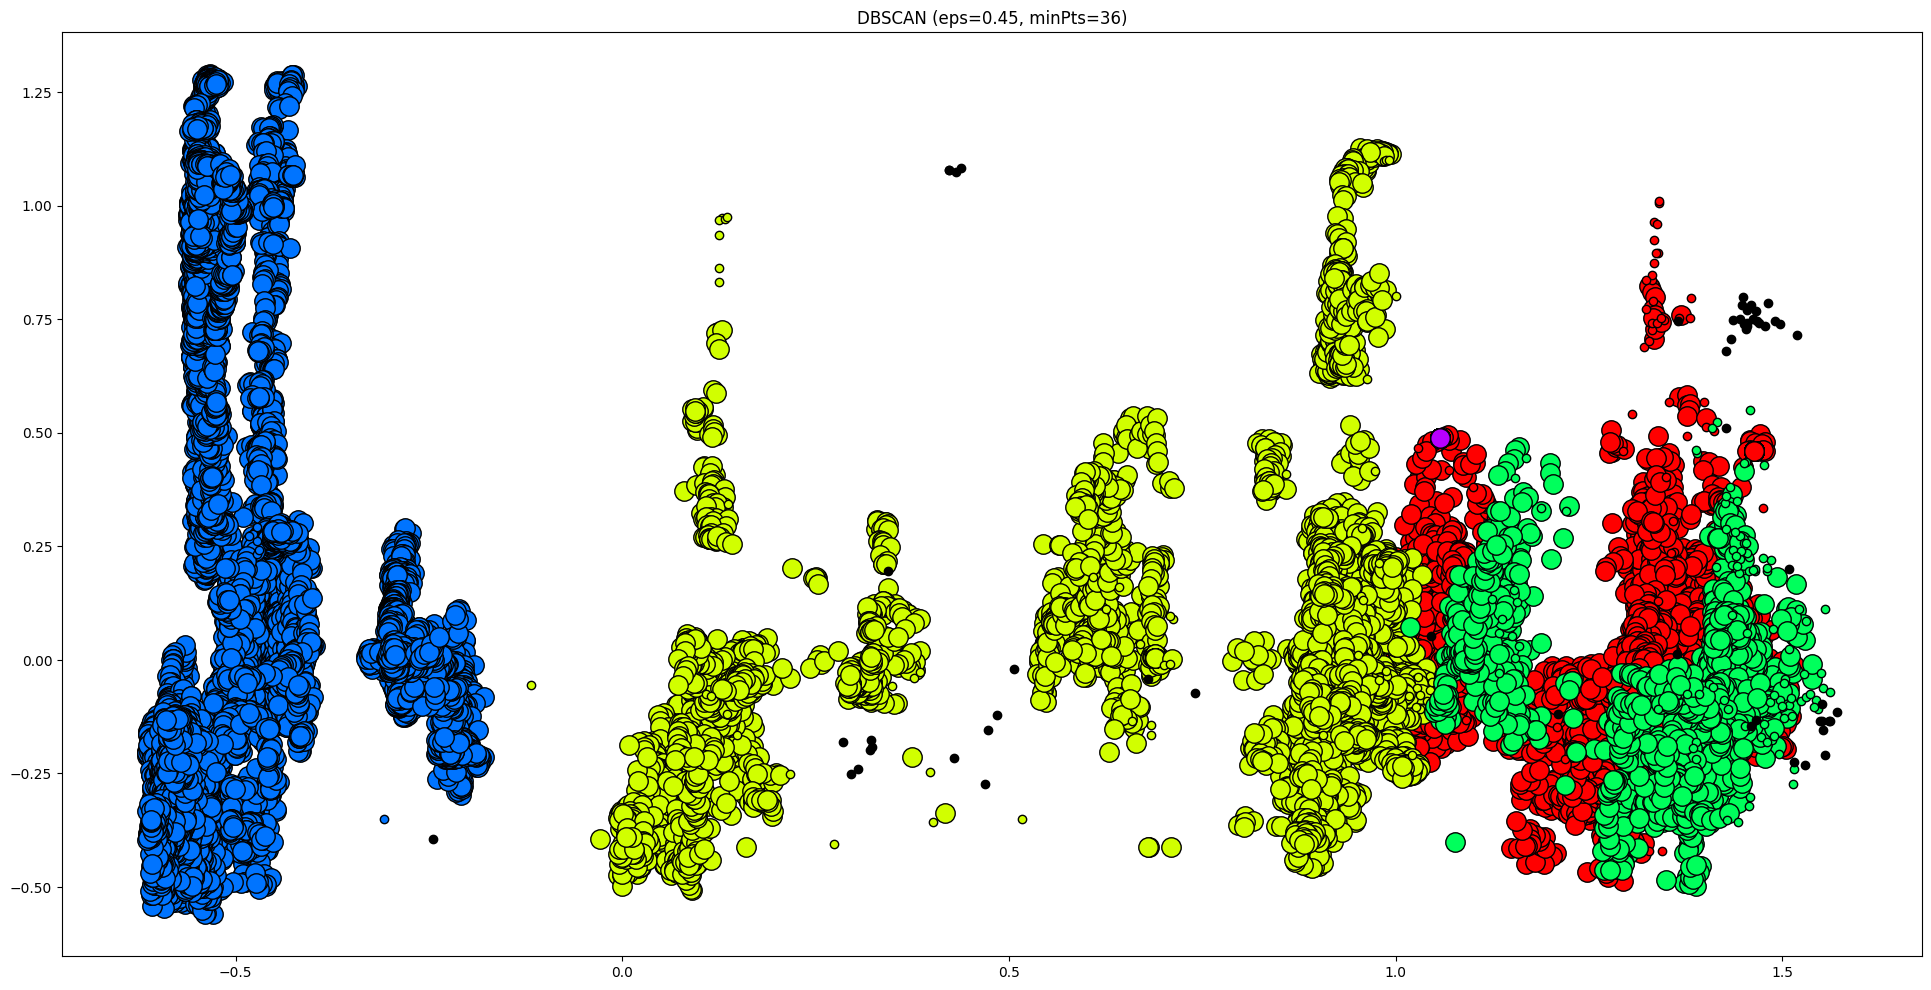

In [25]:
# PCA for visualization
pca = PCA(n_components=2)
pca.fit(scaled_train_data)
pca_train_data = pca.transform(scaled_train_data)

# https://scikit-learn.org/dev/auto_examples/cluster/plot_dbscan.html#plot-results
unique_labels = set(labels)

# create column vector of length n_samples where indices
# with core points are label True, otherwise False.
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.hsv(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(24,12))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0,0,0,1]

    class_member_mask = labels == k

    # core points
    xy = pca_train_data[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    # non-core points
    xy = pca_train_data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"DBSCAN (eps={computed_epsilon}, minPts={computed_minPts})")
plt.show()


# Anomaly Detection
Store the core points and use it to classify new points.

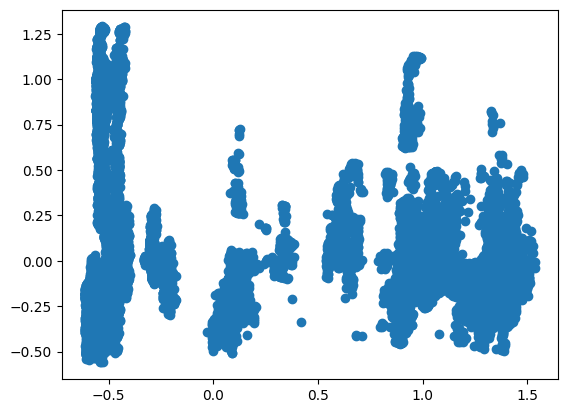

In [26]:
# get core points
core_sample_mask = np.zeros_like(db.labels_, dtype=bool)
core_sample_mask[db.core_sample_indices_] = True
core_points = scaled_train_data[core_sample_mask]

# plot the core points
pca_core_points = pca.transform(core_points)
plt.scatter(pca_core_points[:, 0], pca_core_points[:, 1])
plt.show()

In [27]:
# use kdtree to store core points for fast look up
from scipy.spatial import KDTree
kdtree = KDTree(core_points)

def is_anomaly(point, kdtree, eps):
    dist, _ = kdtree.query(point)
    return dist > eps

In [28]:
df_anomaly = pd.read_csv('./anomaly_detection_dataset_2022/anomaly_testset1.csv')
df_anomaly = df_anomaly.drop(columns=['created_at', 'scene', 'label'])
scaled_anomaly = scaler.transform(df_anomaly)

Number of anomalous points: 307/2880


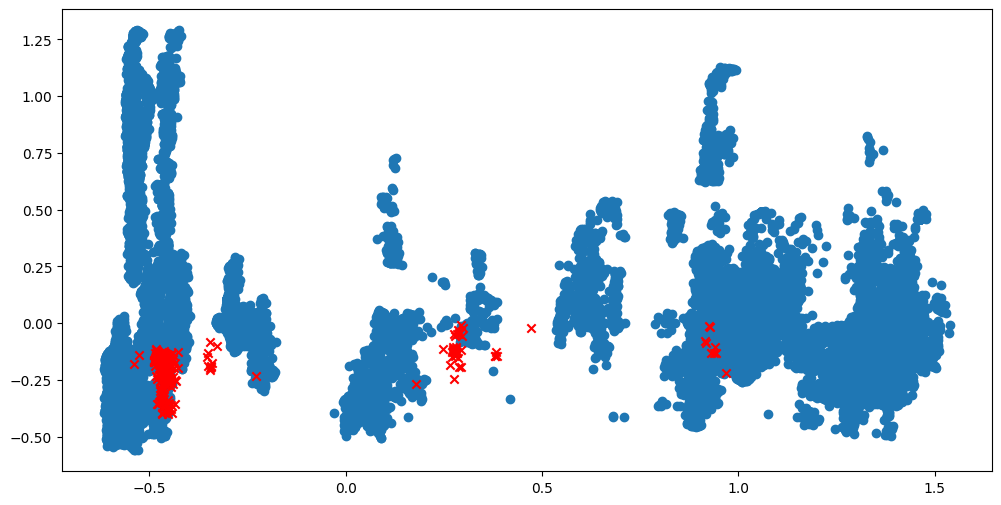

In [29]:
result_mask = is_anomaly(scaled_anomaly, kdtree=kdtree, eps=computed_epsilon)
n_total_points = scaled_anomaly.shape[0]
n_anomalous = list(result_mask).count(True)
print(f'Number of anomalous points: {n_anomalous}/{n_total_points}')

anomalous_points = scaled_anomaly[result_mask]
pca_anomalous_points = pca.transform(anomalous_points)

plt.figure(figsize=(12,6))
plt.scatter(pca_core_points[:, 0], pca_core_points[:, 1])
plt.scatter(pca_anomalous_points[:, 0], pca_anomalous_points[:, 1], marker='x', color='red')
plt.show()
